<a href="https://colab.research.google.com/github/Orri050/Lokaverkefni/blob/main/Lokaverkefni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forritið

## Grunnur

In [900]:
pip install yfinance

In [901]:
pip install plotly

In [902]:
import tensorflow as tf
import math
from pandas.tseries.offsets import DateOffset
from datetime import timedelta, date
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Val á hlutabréfi

In [1724]:
choice = input('Write a stock symbol:')
choice = choice.upper()

Write a stock symbol:AMZN


In [1436]:
islenskt=input('Íslenskt? (1 já), (0 nei):')
islenskt = islenskt.upper()

Íslenskt? (1 já), (0 nei):0


## Hlutabréf gögn

In [1725]:
data = yf.download(tickers=choice, start="2019-03-04", end="2022-04-18", interval='1d')
#data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)

[*********************100%***********************]  1 of 1 completed


In [1726]:
data_Open=data[['Open']] #this returns a DataFrame, you don't need loc
data_dates=data.index.to_frame().reset_index(drop=True)
data_dates=data_dates.apply(pd.to_datetime)

### yf.ticker 

In [1727]:
yf.pdr_override()
stock = yf.Ticker(choice)

In [1728]:
stockh = stock.history(period='max',start="2019-03-04",end="2022-04-18", interval='1d')
#stockh = stock.history(period='max', interval='1d')
stockh

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-04,1685.000000,1709.430054,1674.359985,1696.170044,6167400,0,0
2019-03-05,1702.949951,1707.800049,1689.010010,1692.430054,3681500,0,0
2019-03-06,1695.969971,1697.750000,1668.280029,1668.949951,3996000,0,0
2019-03-07,1667.369995,1669.750000,1620.510010,1625.949951,4957000,0,0
2019-03-08,1604.010010,1622.719971,1586.569946,1620.800049,4667000,0,0
...,...,...,...,...,...,...,...
2022-04-08,3135.000000,3147.370117,3084.620117,3089.209961,2295100,0,0
2022-04-11,3054.260010,3082.729980,3010.689941,3022.439941,2605600,0,0
2022-04-12,3073.850098,3101.979980,3007.659912,3015.750000,2758900,0,0


In [1729]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [1730]:
stockh.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06',
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14'],
              dtype='datetime64[ns]', name='Date', length=788, freq=None)

In [1731]:
stockh_Open=stockh[['Open']] #this returns a DataFrame, you don't need loc
stockh_dates=stockh.index.to_frame().reset_index(drop=True)
stockh_dates=stockh_dates.apply(pd.to_datetime)

In [1732]:
jon=stock.dividends
divi_dates=jon.index.to_frame().reset_index(drop=True)
divi_dates=divi_dates.apply(pd.to_datetime)
print(divi_dates)

Empty DataFrame
Columns: [Date]
Index: []


In [1733]:
add_dates = [data.index[-1] + DateOffset(days=x) for x in range(0,32) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
#future_dates

## Open close

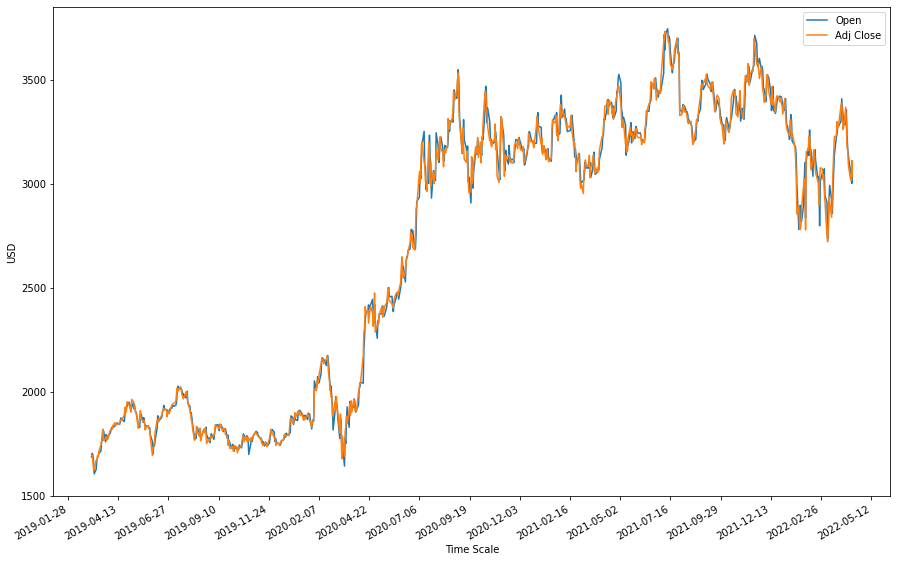

In [1734]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['Open'], label='Open')
plt.plot(x_dates, data['Adj Close'], label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## High low

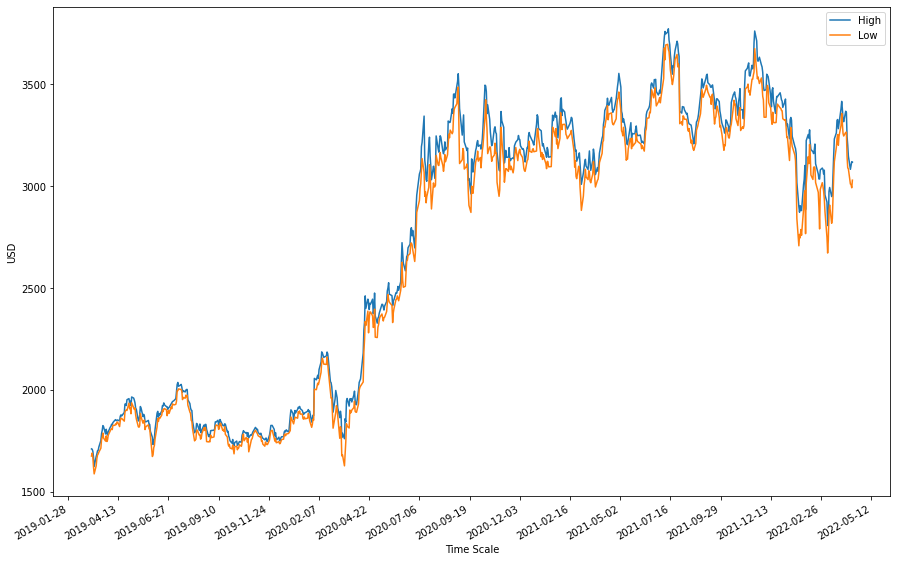

In [1735]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['High'], label='High')
plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Fyrsta módel

### Gagnaundirbúningur

In [1736]:
target_y = data['Adj Close']
X_feat= data.iloc[:,0:5]
h_feat=data.iloc[:,4]

In [1737]:
h_feat

Date
2019-03-04    1696.170044
2019-03-05    1692.430054
2019-03-06    1668.949951
2019-03-07    1625.949951
2019-03-08    1620.800049
                 ...     
2022-04-08    3089.209961
2022-04-11    3022.439941
2022-04-12    3015.750000
2022-04-13    3110.820068
2022-04-14    3034.129883
Name: Adj Close, Length: 788, dtype: float64

In [1738]:
X_feat

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-03-04,1685.000000,1709.430054,1674.359985,1696.170044,1696.170044
2019-03-05,1702.949951,1707.800049,1689.010010,1692.430054,1692.430054
2019-03-06,1695.969971,1697.750000,1668.280029,1668.949951,1668.949951
2019-03-07,1667.369995,1669.750000,1620.510010,1625.949951,1625.949951
2019-03-08,1604.010010,1622.719971,1586.569946,1620.800049,1620.800049
...,...,...,...,...,...
2022-04-08,3135.000000,3147.370117,3084.620117,3089.209961,3089.209961
2022-04-11,3054.260010,3082.729980,3010.689941,3022.439941,3022.439941
2022-04-12,3073.850098,3101.979980,3007.659912,3015.750000,3015.750000


In [1739]:
h_ft=np.array(h_feat)
h_ft=h_ft.reshape(-1,1)

In [1740]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)


In [1741]:
h_ft=sc.fit_transform(h_ft)

In [1742]:
def lstm_split(data, n_steps1):
  X, y=[], []
  for i in range(len(data)-n_steps1+1):
    X.append(data[i:i+n_steps1,:-1])
    y.append(data[i+n_steps1-1,-1])

  return np.array(X), np.array(y)


In [1743]:
X11, y11= lstm_split(X_ft.values, n_steps1=1)

train_split=0.8
split_idx= int(np.ceil(len(X11)*train_split))
date_index=X_ft.index

Xtr1, Xtst1= X11[:split_idx], X11[split_idx:]
ytr1, ytst1= y11[:split_idx], y11[split_idx:]
Xtrd1, Xtstd1= date_index[:split_idx], date_index[split_idx:]

print(X11.shape, Xtr1.shape, Xtst1.shape, ytst1.shape)

(788, 1, 4) (631, 1, 4) (157, 1, 4) (157,)


### Modelið

In [1744]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr1.shape[1],Xtr1.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_193 (LSTM)             (None, 1, 32)             4736      
                                                                 
 lstm_194 (LSTM)             (None, 32)                8320      
                                                                 
 dense_91 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [1745]:
history1=model1.fit(Xtr1,ytr1,epochs=100,validation_data=(Xtst1, ytst1),batch_size=4,verbose=2,shuffle=False)

Epoch 1/100
158/158 - 4s - loss: 0.6152 - val_loss: 0.0175 - 4s/epoch - 25ms/step
Epoch 2/100
158/158 - 1s - loss: 0.0048 - val_loss: 0.0023 - 511ms/epoch - 3ms/step
Epoch 3/100
158/158 - 1s - loss: 0.0019 - val_loss: 0.0021 - 529ms/epoch - 3ms/step
Epoch 4/100
158/158 - 1s - loss: 0.0016 - val_loss: 0.0021 - 513ms/epoch - 3ms/step
Epoch 5/100
158/158 - 1s - loss: 0.0014 - val_loss: 0.0021 - 546ms/epoch - 3ms/step
Epoch 6/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0022 - 513ms/epoch - 3ms/step
Epoch 7/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0021 - 553ms/epoch - 4ms/step
Epoch 8/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0021 - 510ms/epoch - 3ms/step
Epoch 9/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0020 - 534ms/epoch - 3ms/step
Epoch 10/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0020 - 530ms/epoch - 3ms/step
Epoch 11/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0019 - 525ms/epoch - 3ms/step
Epoch 12/100
158/158 - 1s - loss: 0.0012 - val_loss: 0.0018 - 543ms/epoch - 

In [1746]:
ypr=model1.predict(Xtst1)
#ypr=ypr.reshape(-1)

### Lærdómskúrva

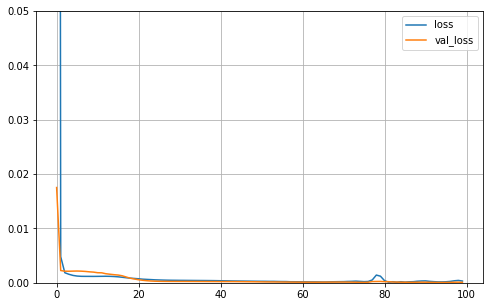

In [1747]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.05)
plt.show()

### Samanburður á raunverulegu close og mati LSTM

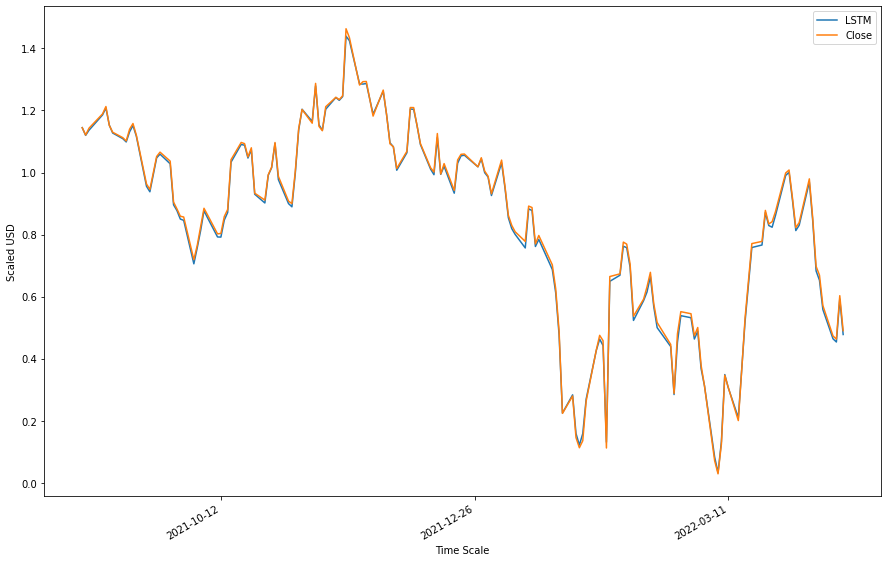

In [1748]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
#h=stockh['Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr, label='LSTM')
plt.plot(x_dates, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [1749]:
rmse=mean_squared_error(ytst1,ypr,squared=False)
mape=mean_absolute_percentage_error(ytst1,ypr)
print("RSME:",rmse)
print("MAPE:",mape)

RSME: 0.00939622721486797
MAPE: 0.015736596419436515


In [1750]:
Villa1 = (rmse+mape)/2

## Annað módel

### Þjálfun á modeli

In [1751]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr1.shape[1],Xtr1.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model2.compile(loss="mean_squared_error", optimizer="adam")
model2.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_195 (LSTM)             (None, 1, 50)             11000     
                                                                 
 lstm_196 (LSTM)             (None, 1, 50)             20200     
                                                                 
 lstm_197 (LSTM)             (None, 50)                20200     
                                                                 
 dense_92 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [1752]:
#history2=model2.fit(Xtr,ytr,epochs=100,batch_size=4,verbose=2,shuffle=False)

In [1753]:
history2 = model2.fit(Xtr1, ytr1, epochs=100, batch_size=50, validation_data=(Xtst1, ytst1), verbose=2, shuffle=False)

Epoch 1/100
13/13 - 6s - loss: 1.0395 - val_loss: 0.8216 - 6s/epoch - 480ms/step
Epoch 2/100
13/13 - 0s - loss: 0.9443 - val_loss: 0.7517 - 89ms/epoch - 7ms/step
Epoch 3/100
13/13 - 0s - loss: 0.7628 - val_loss: 0.5853 - 93ms/epoch - 7ms/step
Epoch 4/100
13/13 - 0s - loss: 0.4121 - val_loss: 0.3231 - 102ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0703 - val_loss: 0.1113 - 102ms/epoch - 8ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0776 - val_loss: 0.0547 - 86ms/epoch - 7ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0100 - val_loss: 0.0128 - 93ms/epoch - 7ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0064 - val_loss: 0.0072 - 105ms/epoch - 8ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0061 - val_loss: 0.0068 - 92ms/epoch - 7ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0050 - val_loss: 0.0072 - 104ms/epoch - 8ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0049 - val_loss: 0.0072 - 111ms/epoch - 9ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0047 - val_loss: 0.0069 - 102ms/epoch - 8ms/step
Epoch 13/100
13/13 

In [1754]:
ypr2=model2.predict(Xtst1)
#ypr2=ypr2.reshape(-1)

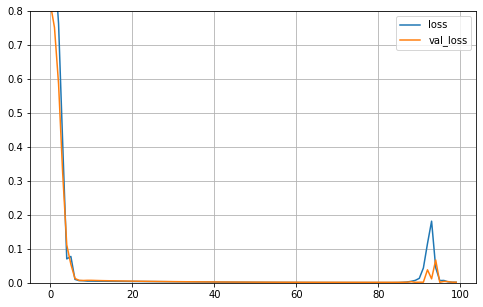

In [1755]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

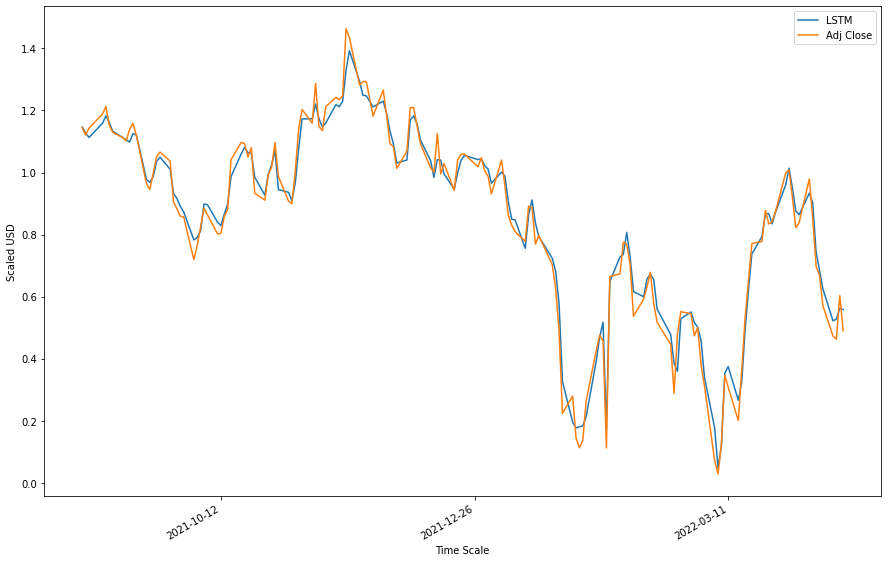

In [1756]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
#h=data['Adj Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr2, label='LSTM')
plt.plot(x_dates, h, label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [1757]:
rmse2=mean_squared_error(ytst1,ypr2,squared=False)
mape2=mean_absolute_percentage_error(ytst1,ypr2)
print("RSME:",rmse2)
print("MAPE:",mape2)

RSME: 0.04112615650622759
MAPE: 0.0724160415880147


In [1758]:
Villa2=(rmse2+mape2)/2

## Þriðja módel

### Þjálfun

In [1759]:
n_steps1=10
X12, y12= lstm_split(X_ft.values, n_steps1=n_steps1)

train_split=0.8
split_idx= int(np.ceil(len(X12)*train_split))
date_index=X_ft.index

Xtr2, Xtst2= X12[:split_idx], X12[split_idx:]
ytr2, ytst2= y12[:split_idx], y12[split_idx:]
Xtrd2, Xtstd2= date_index[:split_idx], date_index[split_idx:-n_steps1+1]

print(X12.shape, Xtr2.shape, Xtst2.shape,Xtstd2.shape, ytst2.shape)

(779, 10, 4) (624, 10, 4) (155, 10, 4) (155,) (155,)


In [1760]:
#model = Sequential()
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.1))
#model.add(LSTM(50))
#model.add(Dropout(0.1))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [1761]:
#model3 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr.shape[1],Xtr.shape[2]), activation="relu",return_sequences=True),
    #keras.layers.LSTM(50,activation="relu"),
    #keras.layers.Dense(1)])
#model3.compile(loss="mean_squared_error", optimizer="adam")
#model3.summary()

In [1762]:
#model3 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr2.shape[1],Xtr2.shape[2]),return_sequences=True),
    #keras.layers.LSTM(50,return_sequences=True),
    #keras.layers.LSTM(50),
    #keras.layers.Dense(1)])
#model3.compile(loss="mean_squared_error", optimizer="adam")
#model3.summary()

In [1763]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
model3.compile(loss="mean_squared_error", optimizer="adam")

In [1764]:
history3 = model3.fit(Xtr2, ytr2, epochs=100, batch_size=50, validation_data=(Xtst2, ytst2), verbose=2, shuffle=False)

Epoch 1/100
13/13 - 6s - loss: 0.4389 - val_loss: 0.0435 - 6s/epoch - 465ms/step
Epoch 2/100
13/13 - 0s - loss: 0.2242 - val_loss: 0.0373 - 195ms/epoch - 15ms/step
Epoch 3/100
13/13 - 0s - loss: 0.1087 - val_loss: 0.0350 - 199ms/epoch - 15ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0851 - val_loss: 0.0349 - 199ms/epoch - 15ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0675 - val_loss: 0.0344 - 210ms/epoch - 16ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0694 - val_loss: 0.0330 - 200ms/epoch - 15ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0610 - val_loss: 0.0321 - 199ms/epoch - 15ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0598 - val_loss: 0.0327 - 197ms/epoch - 15ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0535 - val_loss: 0.0308 - 200ms/epoch - 15ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0503 - val_loss: 0.0302 - 208ms/epoch - 16ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0571 - val_loss: 0.0301 - 198ms/epoch - 15ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0481 - val_loss: 0.0298 - 213ms/epoch - 16ms/step
Epo

In [1765]:
#history3=model3.fit(Xtr2,ytr2,validation_data=(Xtst2,ytst2),epochs=100,batch_size=64,verbose=2)

In [1766]:
ypr3=model3.predict(Xtst2)
#ypr3=ypr3.reshape(-1)

### Lærdómskúrva

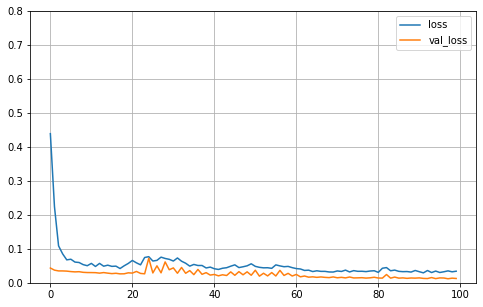

In [1767]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður

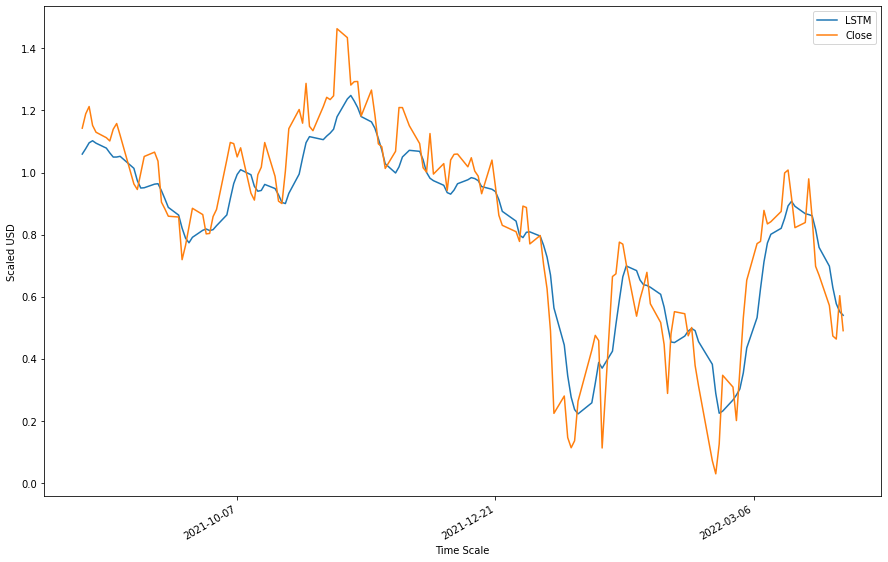

In [1768]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr2)
thri=len(X12)-len(Xtstd2)
x_dates=data_dates[k:]
#h=stockh['Close']
n=n_steps1-1
h=h_ft[thri+n:]
#h=h[k:]
plt.plot(Xtstd2, ypr3, label='LSTM')
plt.plot(Xtstd2, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE

In [1769]:
rmse3=mean_squared_error(ytst2,ypr3,squared=False)
mape3=mean_absolute_percentage_error(ytst2,ypr3)
print("RSME:",rmse3)
print("MAPE:",mape3)

RSME: 0.1127603064686057
MAPE: 0.2452327539760282


In [1770]:
Villa3=(rmse3+mape3)/2

## MAPE

Test RMSE: 215.302
Test MAPE: 0.054


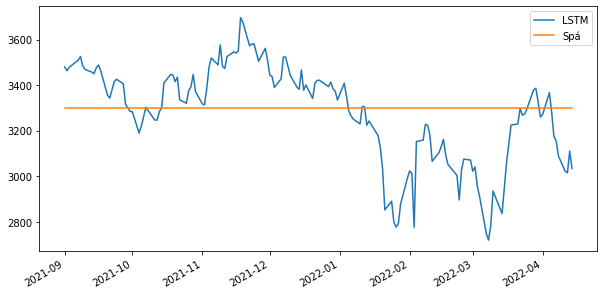

In [1771]:
train_split=0.8
split_idx2= int(np.ceil(len(data)*train_split))
tr=data[['Adj Close']].iloc[:split_idx2]
tst=data[['Adj Close']].iloc[split_idx2:]

tstpr=np.array([tr.rolling(10).mean().iloc[-1]]*len(tst)).reshape((-1,1))

print('Test RMSE: %.3f'%mean_squared_error(tst,tstpr,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst,tstpr))
f=len(tst)-len(h)
z=n-f
x_dates=data_dates[k+z:]


plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst, label='LSTM')
plt.plot(x_dates, tstpr, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Test RMSE: 226.875
Test MAPE: 0.055


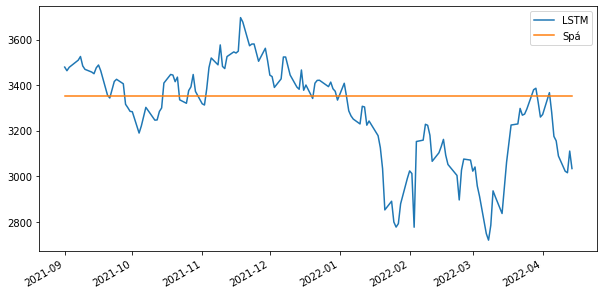

In [1772]:
from statsmodels.tsa.api import SimpleExpSmoothing

J=data[['Adj Close']].values
train_split=0.8
split_idx3= int(np.ceil(len(J)*train_split))
tr2=J[:split_idx3]
tst2=J[split_idx3:]
tst_concat=np.array([]).reshape((0,1))

for i in range(len(tst2)):
  tr_fit=np.concatenate((tr2,np.asarray(tst_concat)))
  fit=SimpleExpSmoothing(np.asarray(tr_fit)).fit(smoothing_level=0.2)
  tst_pr=fit.forecast(1)
  tst_concat=np.concatenate((np.asarray(tst_concat),tst_pr.reshape((-1,1))))

print('Test RMSE: %.3f'%mean_squared_error(tst2,tst_concat,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst2,tst_concat))
f=len(tst2)-len(h)
z=n-f
x_dates=data_dates[k+z:]

plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst2, label='LSTM')
plt.plot(x_dates, tst_concat, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


## Val á modeli með minnstu villuna

In [1773]:
smallest = 0
if Villa1 < Villa2 and Villa1 < Villa3 :
    smallest = 'Model1'
if Villa2 < Villa1 and Villa2 < Villa3 :
    smallest = 'Model2'
if Villa3 < Villa1 and Villa3 < Villa2 :
    smallest = 'Model3'
print(smallest, "er með minnstu samanlögðu meðalvilluna.")
print("Við veljum þá", smallest)

Model1 er með minnstu samanlögðu meðalvilluna.
Við veljum þá Model1


## fram í tímann

### val á gögnum

In [1774]:
df1=data.reset_index()['Adj Close']
df1.shape

(788,)

### Mynd af gögnum sem voru valin

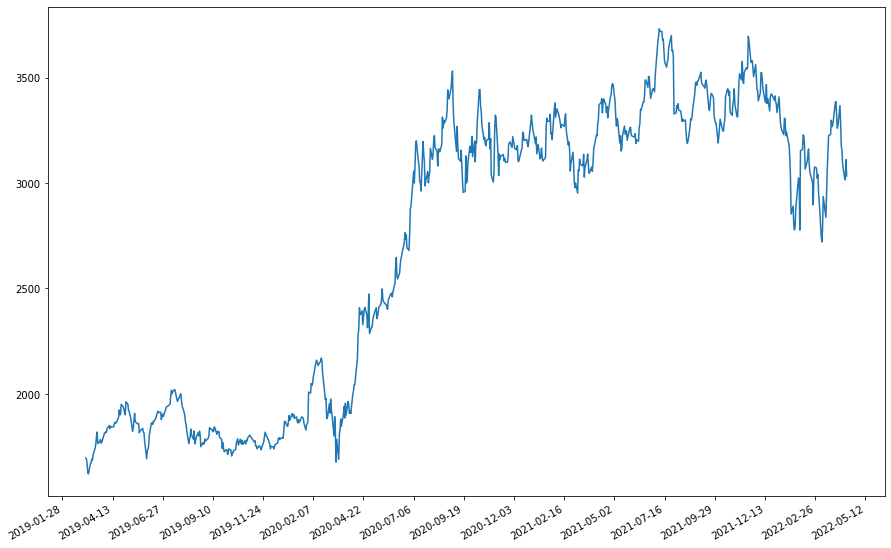

In [1775]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
x_dates=data_dates
#plt.plot(df1)
plt.plot(x_dates, df1, label='Close')
plt.gcf().autofmt_xdate()

### Gagnavinnsla

In [1776]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [1777]:
#print(df1)

In [1778]:
trainstaerd=int(len(df1)*0.65)
tststaerd=len(df1)-trainstaerd
train_data,test_data=df1[0:trainstaerd,:],df1[trainstaerd:len(df1),:1]

In [1779]:
trainstaerd,tststaerd

(512, 276)

In [1780]:
#train_data

In [1781]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [1782]:
time_step = 100
Xtr3, ytr3 = create_dataset(train_data, time_step)
Xtst3, ytst3 = create_dataset(test_data, time_step)

In [1783]:
print(Xtr3.shape)
print(ytr3.shape)

(411, 100)
(411,)


In [1784]:
print(Xtst3.shape), print(ytst3.shape)

(175, 100)
(175,)


(None, None)

In [1785]:
Xtr3 =Xtr3.reshape(Xtr3.shape[0],Xtr3.shape[1] , 1)
Xtst3 = Xtst3.reshape(Xtst3.shape[0],Xtst3.shape[1] , 1)

In [1786]:
#model1 = keras.models.Sequential([
    #keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    #keras.layers.LSTM(32),
    #keras.layers.Dense(1)])
#model1.compile(loss="mean_squared_error", optimizer="adam")
#model1.summary()

### Modelið

In [ ]:

if smallest=='Model1' :
    print("Við notum Model1")
    model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
    model1.compile(loss="mean_squared_error", optimizer="adam")
    model1.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=4,verbose=2)   
if smallest=='Model2' :
    print("Við notum Model2")
    model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
    model2.compile(loss="mean_squared_error", optimizer="adam")
    model2.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 
if smallest=='Model3' :
    print("Við notum Model3")
    model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
    model3.compile(loss="mean_squared_error", optimizer="adam")
    model3.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 

Við notum Model1
Epoch 1/100
103/103 - 10s - loss: 0.0364 - val_loss: 0.0048 - 10s/epoch - 95ms/step
Epoch 2/100
103/103 - 7s - loss: 0.0034 - val_loss: 0.0053 - 7s/epoch - 63ms/step
Epoch 3/100
103/103 - 7s - loss: 0.0029 - val_loss: 0.0038 - 7s/epoch - 64ms/step
Epoch 4/100
103/103 - 7s - loss: 0.0023 - val_loss: 0.0033 - 7s/epoch - 63ms/step
Epoch 5/100
103/103 - 7s - loss: 0.0018 - val_loss: 0.0028 - 7s/epoch - 64ms/step
Epoch 6/100
103/103 - 6s - loss: 0.0016 - val_loss: 0.0041 - 6s/epoch - 63ms/step
Epoch 7/100
103/103 - 7s - loss: 0.0017 - val_loss: 0.0026 - 7s/epoch - 63ms/step
Epoch 8/100
103/103 - 7s - loss: 0.0015 - val_loss: 0.0027 - 7s/epoch - 63ms/step
Epoch 9/100
103/103 - 7s - loss: 0.0015 - val_loss: 0.0024 - 7s/epoch - 63ms/step
Epoch 10/100
103/103 - 7s - loss: 0.0014 - val_loss: 0.0024 - 7s/epoch - 65ms/step
Epoch 11/100
103/103 - 6s - loss: 0.0016 - val_loss: 0.0023 - 6s/epoch - 63ms/step
Epoch 12/100
103/103 - 6s - loss: 0.0013 - val_loss: 0.0037 - 6s/epoch - 63ms

In [ ]:
#model6 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    #keras.layers.LSTM(50,return_sequences=True),
    #keras.layers.LSTM(50),
    #keras.layers.Dense(1)])
#model6.compile(loss="mean_squared_error", optimizer="adam")
#model6.summary()

In [ ]:
#model6.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=64,verbose=2)

### Spágögn búin til

In [ ]:
mod=0
if smallest=='Model1' :
  train_predict=model1.predict(Xtr3)
  test_predict=model1.predict(Xtst3)
  mod=model1
if smallest=='Model2' :
  train_predict=model2.predict(Xtr3)
  test_predict=model2.predict(Xtst3)
  mod=model2
if smallest=='Model3' :
  train_predict=model3.predict(Xtr3)
  test_predict=model3.predict(Xtst3)
  mod=model3

In [ ]:
#train_predict=model6.predict(Xtr3)
#test_predict=model6.predict(Xtst3)

In [ ]:
  #train_predict=train_predict.reshape(-2)
  #test_predict=test_predict.reshape(-2)

In [ ]:
#train_predict=train_predict.reshape(-1,1)
#test_predict=test_predict.reshape(-1,1)

In [ ]:
#train_predict = train_predict.reshape((train_predict[0],train_predict[1]*train_predict[2]))

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### RMSE 

In [ ]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(ytr3,train_predict))

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytst3,test_predict))

### Mynd af einhverju (skoða)

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=80))
x_dates=data_dates
plt.plot(data_dates,scaler.inverse_transform(df1),label='Spá útfrá test gögnum')
plt.plot(data_dates,trainPredictPlot, label='Öll gögn')
plt.plot(data_dates,testPredictPlot,label='Spá útfrá train gögnum')
plt.legend(['Öll gögn', 'Spá útfrá train gögnum','Spá útfrá test gögnum'],loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

### Framtíðargögn sett í fylki

In [ ]:
len(test_data)

In [ ]:
timi=len(test_data)-100


In [ ]:
x_input=test_data[timi:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
#temp_input

In [ ]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = mod.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = mod.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

In [ ]:
tim=len(df1)-100

### Mynd af spá ósamsett

In [ ]:
#df1.shape

In [ ]:
fdata = pd.concat([data, future_dates], axis=0)
framtid=fdata.index.to_frame().reset_index(drop=True)
framtid=framtid.apply(pd.to_datetime)
len(framtid)

In [ ]:
spat=len(framtid)-30
sidf=len(framtid)-130

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[sidf:spat],scaler.inverse_transform(df1[tim:]))
plt.plot(framtid[spat:],scaler.inverse_transform(lst_output))
plt.gcf().autofmt_xdate()

In [ ]:
timm=tim+30

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)

In [ ]:
laga=0
if len(framtid)!=len(df3):
  laga=len(framtid)-len(df3)


In [ ]:
islenskt=int(islenskt)

### Mynd af spá samsett

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[timm+laga:],df3[timm:])
plt.gcf().autofmt_xdate()

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

### Mynd af heildargögnum með spá

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[laga:],df3)
plt.gcf().autofmt_xdate()

## Nett grafdót

In [ ]:
choice = input('Write a stock symbol:')
choice = choice.upper()
data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.index,open = data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name = 'market data'))
fig.add_trace(go.Scatter(x=data.index,y=data['MA5'],opacity=0.7,line=dict(color='blue', width=2),name='MA 5'))

fig.add_trace(go.Scatter(x=data.index,y=data['MA20'],opacity=0.7,line=dict(color='orange', width=2),name='MA 20'))
fig.update_layout(title = choice + ' share price', yaxis_title = 'Stock Price (USD)')
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
#dict(count=15, label='15m', step='minute', stepmode='backward'),
#dict(count=45, label='45m', step='minute', stepmode='backward'),
#dict(count=1, label='1h', step='hour', stepmode='backward'),
#dict(count=6, label='6h', step='hour', stepmode='backward'),
dict(count=30, label='30d', step='day', stepmode='backward'),
dict(count=3, label='3m', step='month', stepmode='backward'),
dict(count=6, label='6m', step='month', stepmode='backward'),
dict(count=1, label='YTD', step='year', stepmode='todate'),
dict(count=1, label='1y', step='year', stepmode='backward'),
dict(count=3, label='3y', step='year', stepmode='backward'),
dict(step='all')
])
)
)
fig.show()